## Welcome Paul

This is a notebook made specifi

In [1]:
import re
import torch
import torch.nn as nn
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, random_split
from copy import deepcopy
from torch import cuda
import copy
from tqdm import tqdm
from torch.optim import AdamW


Dataloader (SpeechDataset class)

In [2]:
SEED = 42  # defining a seed to facilitate replication
device = 'cuda' if cuda.is_available() else 'cpu'

/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir, load_method):
        """
        :flac_dir
        """
        self.audio_path_list = sorted(self.find_files(flac_dir)) 
        methods = {"librosa": self.librosa_flac2melspec, "soundfile": self.sf_loader, "torchaudio": self.torch_flac2melspec}
        self.labels = {"es": 0, "en": 1, "de": 2}
        self.languages = {v: k for k, v in self.labels.items()}
        self.chosen_method = methods[load_method]
        
        
    def __len__(self):
        return len(self.audio_path_list)

    def __getitem__(self, index):
        audio_file = self.audio_path_list[index]  
        label = self.labels[self.get_label(audio_file)]
        spectro, _ = self.chosen_method(audio_file)  # _ is fs
        #spectro = torch.from_numpy(spectro)
        #spectro = spectro.unsqueeze(0)
        return spectro, label

    def find_files(self, directory, pattern=".flac"):
        """
        Recursive search method to find files. Credit to Paul Magron and Andrea de Marco
        for OG method
        """

        regexFlac = re.compile(rf'/.*fragment\d+\{pattern}$') 
        files = [f.path for f in os.scandir(directory) if regexFlac.search(f.path)]  # ends with does not like regex
        return files
    
    def monolingual_path_list(self, language, gender):
        """
        Input: string ('en'|'de'|'es')
        Output: audio path list only containing file names of the chosen language
        """
        #r = re.compile(rf'.*\/{language}_{gender}.*fragment\d+\.flac') 
        r = re.compile(rf'.*\/{language}.*fragment\d+\.flac') 
        newlist = list(filter(r.match, self.audio_path_list))
        return newlist
    
    def get_label(self, path):
        labelRegex = re.compile(r"(es|en|de)_.*.flac")
        patterns = labelRegex.findall(path)
        assert len(patterns) == 1
        return patterns[0]

    def torch_flac2melspec(self, file_path):
        pass  # commenting option to avoid pip issues on colab
        #waveform, sample_rate = torchaudio.load(file_path, normalize=True)
        #transform = T.MelSpectrogram(sample_rate)        
        #return transform(waveform), sample_rate
        
    def sf_loader(self, file_path):
        with open(file_path, "rb") as f:
            data, samplerate = sf.read(f)
        return data, samplerate

    def librosa_flac2melspec(self, file_path, n_mels=64, melspec_size=512, visual=False):
        """
        the librosa method we are using atm
        """
        sig, fs =  librosa.load(file_path, sr=None)
        sig /= np.max(np.abs(sig), axis=0)
        n_fft = melspec_size
        hop_length = int(n_fft/2)

        # padding signal if less than a second
        if len(sig) < fs:
            padded_array = np.zeros(fs)
            padded_array[:np.shape(sig)[0]] = sig
            sig = padded_array

        melspec = librosa.feature.melspectrogram(y=sig, sr=fs,
                                                 center=True, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)


        if visual:
            self.plotmelspec(melspec, fs, hop_length)

        melspec = librosa.power_to_db(melspec, ref=1.0)
        melspec /= 80.0  # highest db...
        melspec = self.checkmelspec(melspec)
        return melspec, fs

    def checkmelspec(self, melspec, n_mels=64):
        """
        this method works with librosa

        """
        if melspec.shape[1] < n_mels:  # n_mels
            shape = np.shape(melspec)
            padded_array = np.zeros((shape[0], n_mels)) - 1
            padded_array[0:shape[0], :shape[1]] = melspec
            melspec = padded_array
        return melspec

    def plotmelspec(self, melspec, fs, hop_length, show=False):
        plt.figure(figsize=(8, 6))
        plt.xlabel("Time")
        plt.ylabel("Mel-Frequency")
        librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                                 y_axis="mel", fmax=fs/2, sr=fs,
                                 hop_length=hop_length, x_axis="time")
        plt.colorbar(format="%+2.0f db")
        plt.title("Mel Spectogram")
        plt.tight_layout()
        if show:
            plt.show()
        plt.close()  # to close windows and fix warning!

Function to get balanced subset:

In [4]:
def get_balanced_subset(train_data, n, gender):
    '''
    Creates subset with equal amounts of data from each language
    Input: instance of class Speechdataset, desired number of files per language (int) 
    Output: balanced subset (torch.utils.data.dataset.ConcatDataset)
    '''
    #create new instances for each language
    en=deepcopy(train_data)
    es=deepcopy(train_data)
    de=deepcopy(train_data)
    
    
    #modify the audio_path_list to only include paths to files of a single language
    en.audio_path_list=en.monolingual_path_list('en', gender)
    es.audio_path_list=es.monolingual_path_list('es', gender)
    de.audio_path_list=de.monolingual_path_list('de', gender)

    #extract equally sized subsets from each monolingual dataset
    en_sub = Subset(en, torch.arange(n))
    es_sub = Subset(es, torch.arange(n))
    de_sub = Subset(de, torch.arange(n))
    
    subset=en_sub+de_sub+es_sub #concatenate subsets
    return subset

utils.py

In [5]:
# https://debuggercafe.com/saving-and-loading-the-best-model-in-pytorch/

def evaluation(model, val_data, loss_fn):

    device = 'cuda' if cuda.is_available() else 'cpu'

    model.eval()
    with torch.no_grad():
        correct = 0
        loss = 0
        total = 0
        for spectra, labels in val_data:

            spectra = spectra.unsqueeze(1)
            spectra = spectra.to(device)
            labels = labels.to(device)
            preds = model(spectra)
            vals, labels_preds = torch.max(preds.data, 1)  # preds.data == preds? vals are not needed
            total += labels.size(0)  # same as shape[0], what's more pytorch-like?
            correct += (labels_preds == labels).sum().item()
            # loss
            err = loss_fn(preds, labels)
            loss += err.item()
        total_loss = loss / len(val_data)
    return correct / total * 100, total_loss

def visualize(epochs, tr_loss, val_loss, save=False):

    fig = plt.figure()
    train, = plt.plot(torch.arange(epochs) + 1, tr_loss, '-og', label="Train")  
    valid, = plt.plot(torch.arange(epochs) + 1, val_loss, '-or', label="Valid")  
    plt.xlabel('Epochs')
    plt.ylabel("Loss")    
    plt.legend(handles=[train, valid])
    plt.title('Loss over epochs')
    if save:
        fig.savefig("Loss_over_epochs.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'model_output/final_speech_cnn.pth')

plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    #def __init__(self, best_valid_loss=float('inf')):
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        #self.path = "./model_output/best_speech_cnn.pth"
        self.path = "model_output/best_speech_cnn.pth"
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion}, self.path)

CNNSpeechClassifier Module

In [6]:
class CNNSpeechClassifier(nn.Module):

    def __init__(self, channel_inputs, num_channels1, num_channels2, kernel_size, kernel_pool, padding, num_classes):
        num_channels3 = 64
        super(CNNSpeechClassifier, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(channel_inputs, num_channels1, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels1),
                                        nn.MaxPool2d(kernel_pool))


        self.dropout = nn.Dropout(0.25)
        self.fc_layer = nn.Linear(num_channels1*31*430, num_classes)  # shape of cnn_layer 1 after convolution of image!
        
        #self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=kernel_size, padding=padding),
        #                                nn.ReLU(),
        #                                nn.BatchNorm2d(num_channels2),
        #                                nn.MaxPool2d(kernel_pool))

        ##self.fc_layer = nn.Linear(num_channels2*15*214, num_classes)  # shape of cnn_layer 2 after convolution of image!

        #self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=kernel_size, padding=padding),
        #                                nn.ReLU(),
        #                                nn.BatchNorm2d(num_channels3),
        #                                nn.MaxPool2d(kernel_pool))
        #

        #self.fc_layer = nn.Linear(num_channels3*7*106, num_classes)  # shape of cnn_layer 2 after convolution of image!

    def forward(self, x):
        # 1, 8, 64, 862 should be 8, 1, 64, 862
        x = self.cnn_layer1(x)
        #print(x.shape)
        #x = self.cnn_layer2(x)
        ##print(x.shape)
        #x = self.cnn_layer3(x)
        #print(x.shape)
        #raise SystemExit
        # vectorizing image
        z = x.reshape(x.shape[0], -1)
        z = self.dropout(z)
        return self.fc_layer(z)


train.py

In [7]:
class MyTrainer:

    def __init__(self, model, lr=1e-6):

        self.device = 'cuda' if cuda.is_available() else 'cpu'

        self.total_train_loss = []
        self.total_val_loss = []
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = copy.deepcopy(model)
        self.model.to(self.device)
        self.model.train()
        lr = 5e-4  # 5e-4 best so far?
        self.optimizer = AdamW(self.model.parameters(), lr=lr)

    def train_loop(self, train_data, val_data, epochs=10, verbose=True, visual=False):

        save_best_model = SaveBestModel()

        for epoch in tqdm(range(epochs)):
            loss_curr_epoch = 0
            for spectra, labels in train_data:
                self.optimizer.zero_grad()

                spectra = spectra.unsqueeze(1)

                spectra = spectra.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(spectra)  # 8, 3
                loss = self.loss_fn(preds, labels)
                loss.backward()
                self.optimizer.step()

                loss_curr_epoch += loss.item()

            train_loss = loss_curr_epoch / len(train_data)
            self.total_train_loss.append(train_loss)
            acc, val_loss = evaluation(self.model, val_data, self.loss_fn)
            self.total_val_loss.append(val_loss)
            if verbose:
                self.pretty_print(epoch=epoch, train_loss=train_loss, val_loss=val_loss, acc=acc)

            save_best_model(val_loss, epoch, self.model, self.optimizer, self.loss_fn)


        
        if visual:
            visualize(epochs, self.total_train_loss, self.total_val_loss)
        save_model(epochs=epochs, model=self.model, optimizer=self.optimizer, criterion=self.loss_fn)
    
    def pretty_print(self, epoch, train_loss, val_loss, acc):
        print(f"Epoch {epoch+1}: train loss is {train_loss:.3f} | val loss is {val_loss:.3f} | Accuracy is {acc:.2f}%")

eval.py

# Train

In [8]:
train_dir = "./Dataset/train/train"
train_data = SpeechDataset(train_dir, "librosa")

train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True) 
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

 10%|████▍                                       | 1/10 [01:07<10:06, 67.43s/it]

Epoch 1: train loss is 11.689 | val loss is 15.570 | Accuracy is 45.04%

Best validation loss: 15.570100209069631

Saving best model for epoch: 1



 20%|████████▊                                   | 2/10 [02:12<08:49, 66.21s/it]

Epoch 2: train loss is 3.994 | val loss is 6.284 | Accuracy is 52.98%

Best validation loss: 6.283751318497317

Saving best model for epoch: 2



 30%|█████████████▏                              | 3/10 [03:16<07:35, 65.10s/it]

Epoch 3: train loss is 1.286 | val loss is 5.220 | Accuracy is 59.13%

Best validation loss: 5.219585657248004

Saving best model for epoch: 3



 40%|█████████████████▌                          | 4/10 [04:21<06:29, 65.00s/it]

Epoch 4: train loss is 0.544 | val loss is 5.961 | Accuracy is 57.94%


 50%|██████████████████████                      | 5/10 [05:26<05:24, 64.95s/it]

Epoch 5: train loss is 0.343 | val loss is 7.310 | Accuracy is 56.55%


 60%|██████████████████████████▍                 | 6/10 [06:31<04:19, 64.91s/it]

Epoch 6: train loss is 0.262 | val loss is 8.608 | Accuracy is 53.57%


 70%|██████████████████████████████▊             | 7/10 [07:35<03:13, 64.62s/it]

Epoch 7: train loss is 0.228 | val loss is 6.597 | Accuracy is 60.71%


 80%|███████████████████████████████████▏        | 8/10 [08:38<02:08, 64.30s/it]

Epoch 8: train loss is 0.176 | val loss is 9.796 | Accuracy is 55.36%


 90%|███████████████████████████████████████▌    | 9/10 [09:43<01:04, 64.59s/it]

Epoch 9: train loss is 0.172 | val loss is 7.307 | Accuracy is 58.93%


100%|███████████████████████████████████████████| 10/10 [10:48<00:00, 64.81s/it]

Epoch 10: train loss is 0.225 | val loss is 7.291 | Accuracy is 60.32%


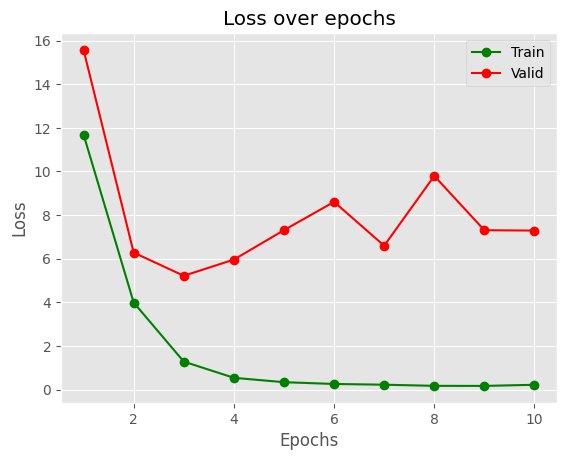

Saving final model...


In [9]:
CNN_model = CNNSpeechClassifier(channel_inputs=1, num_channels1=16,
                                num_channels2=32, kernel_size=2,
                                kernel_pool=2, padding=0, num_classes=3)


trainer = MyTrainer(CNN_model)
trainer.train_loop(train_dataloader, val_dataloader, visual=True)

# Test

In [12]:
def load_components(checkpoint):


    epoch = checkpoint["epoch"]
    loss_fn = checkpoint["loss"]
    #loss_fn = nn.CrossEntropyLoss()

    model = CNNSpeechClassifier(channel_inputs=1, num_channels1=16,
                                num_channels2=32, kernel_size=2,
                                kernel_pool=2, padding=0, num_classes=3)


    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    model.to(device)

    return model, optimizer, epoch, loss_fn


Main

In [11]:
test_dir = "./Dataset/test/test"

test_data = SpeechDataset(test_dir, "librosa")
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)  # one is 4, 64, 862 - 4 despite batch size

best_checkpoint = torch.load("model_output/best_speech_cnn.pth", map_location=device)  # weird form of early stopping. Should add patience
final_checkpoint = torch.load("model_output/final_speech_cnn.pth", map_location=device)
model, optimizer, epoch, loss_fn = load_components(best_checkpoint)

acc, test_loss = evaluation(model, test_dataloader, loss_fn)

print(f"Best epoch {epoch}: test loss is {test_loss:.3f} | Accuracy is {acc:.2f}%")

Best epoch 3: test loss is 5.257 | Accuracy is 63.15%
